## Importing Libraries

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import networkx as nx
# from google.colab import drive
import warnings

warnings.filterwarnings('ignore')

## Importing Dataset

In [22]:
 # drive.mount('/content/drive')

In [23]:
# Load all datasets
matches = pd.read_csv('matches.csv')
teams = pd.read_csv('teams.csv')

## Data Preprocessing and Feature Engineering

In [24]:
# Feature Engineering and Preprocessing without computing outcome
def preprocess_data(matches):
    # Label encode the team names (home and away)
    all_teams = pd.concat([matches['home_team_name'], matches['away_team_name']]).unique()
    le = LabelEncoder()
    le.fit(all_teams)

    # Encode home and away team names
    matches['home_team_encoded'] = le.transform(matches['home_team_name'])
    matches['away_team_encoded'] = le.transform(matches['away_team_name'])

    # Calculate recent form based on past match results
    matches['home_team_form'] = matches['home_team_score_margin']  # Margin of victory in previous matches
    matches['away_team_form'] = matches['away_team_score_margin']  # Margin of victory in previous matches

    # Goals scored and conceded from the dataset
    matches['home_team_goals'] = matches['home_team_score']  # Known before the match
    matches['away_team_goals'] = matches['away_team_score']  # Known before the match

    return matches

# Apply the preprocessing function
matches = preprocess_data(matches)

In [25]:
# Deriving the match outcome from available columns (1 = home win, 2 = away win, 0 = draw)
def derive_match_outcome(row):
    if row['home_team_win'] == 1:
        return 1  # Home win
    elif row['away_team_win'] == 1:
        return 2  # Away win
    else:
        return 0  # Draw

matches['outcome'] = matches.apply(derive_match_outcome, axis=1)

## Exploratory Data Analysis

### Correlation Heatmap

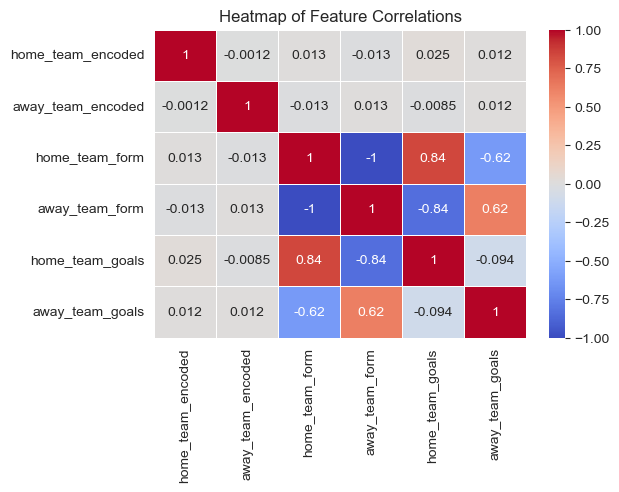

In [26]:
numeric_cols = matches[['home_team_encoded', 'away_team_encoded', 'home_team_form', 'away_team_form',
                        'home_team_goals', 'away_team_goals']]

plt.figure(figsize=(6, 4))
sns.heatmap(numeric_cols.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Heatmap of Feature Correlations')
plt.show()

## Random Forest Classifier

### Train Test Split

In [27]:
# Select features for model training
X = matches[['home_team_encoded', 'away_team_encoded', 'home_team_form', 'away_team_form',
             'home_team_goals', 'away_team_goals']]
y = matches['outcome']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Model Training

In [28]:
# Hyperparameter Tuning using RandomizedSearchCV
param_distributions = {
    'n_estimators': [100, 200, 500],
    'max_depth': [5, 10, 15],  # Limit depth to prevent overfitting
    'min_samples_split': [5, 10, 20],  # Increase minimum samples required to split a node
    'min_samples_leaf': [4, 6, 8],  # Increase minimum samples required at leaf nodes
    'bootstrap': [True, False]
}

rf = RandomForestClassifier(random_state=42)
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_distributions,
                                   n_iter=20, cv=3, random_state=42, n_jobs=-1, verbose=2)

# Fit the model
random_search.fit(X_train, y_train)

# Best parameters from random search
print(f"Best Parameters: {random_search.best_params_}")

# Use the best model from random search
best_rf = random_search.best_estimator_

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Parameters: {'n_estimators': 500, 'min_samples_split': 10, 'min_samples_leaf': 8, 'max_depth': 15, 'bootstrap': False}


### Model Evaluation

In [29]:
# Predictions and evaluation
y_pred = best_rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f'Random Forest Classifier Metrics after Tuning:\nAccuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1-Score: {f1}')

Random Forest Classifier Metrics after Tuning:
Accuracy: 0.964
Precision: 0.9708936170212765
Recall: 0.964
F1-Score: 0.9654759965309702


### Feature Importance

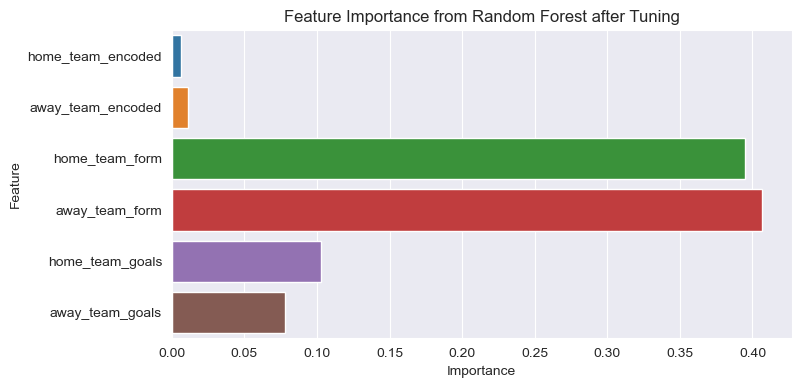

In [30]:
# Feature Importance Visualization
importances = best_rf.feature_importances_
feature_names = ['home_team_encoded', 'away_team_encoded', 'home_team_form', 'away_team_form',
                 'home_team_goals', 'away_team_goals']

plt.figure(figsize=(8, 4))
sns.barplot(x=importances, y=feature_names)
plt.title('Feature Importance from Random Forest after Tuning')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

## K-Means Clustering

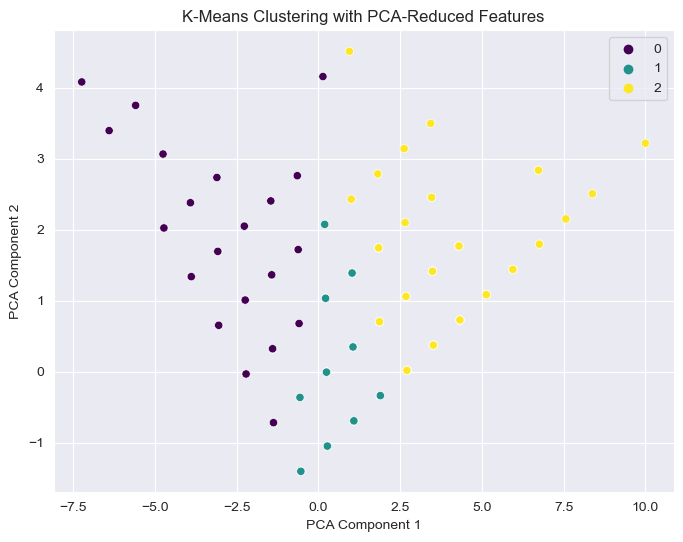

In [31]:
# Scaling the performance-related features
X_clustering = matches[['home_team_form', 'away_team_form', 'home_team_goals', 'away_team_goals']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clustering)

# Apply PCA to reduce dimensionality to 2D for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Applying K-Means Clustering to the reduced PCA components
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_clusters = kmeans.fit_predict(X_pca)

# Visualizing the clusters with PCA-reduced features
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=kmeans_clusters, palette='viridis')
plt.title('K-Means Clustering with PCA-Reduced Features')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

In [32]:
# Add description for each K-Means cluster
matches['cluster'] = kmeans_clusters
# Exclude non-numeric columns from mean calculation
numeric_columns = matches.select_dtypes(include=[np.number]).columns

# Now, perform the groupby and mean operation only on numeric columns
cluster_summary = matches.groupby('cluster')[numeric_columns].mean()[['home_team_goals', 'away_team_goals', 'home_team_form', 'away_team_form']]
print("Cluster Summary (Average Performance Metrics):")
print(cluster_summary)

Cluster Summary (Average Performance Metrics):
         home_team_goals  away_team_goals  home_team_form  away_team_form
cluster                                                                  
0               0.761273         2.294430       -1.533156        1.533156
1               1.696477         0.573171        1.123306       -1.123306
2               5.375940         0.714286        4.661654       -4.661654


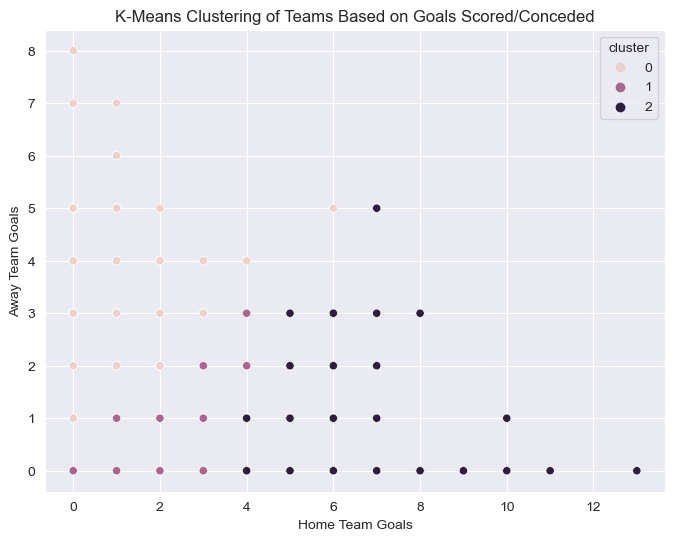

In [33]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=matches['home_team_goals'], y=matches['away_team_goals'], hue=matches['cluster'])
plt.title('K-Means Clustering of Teams Based on Goals Scored/Conceded')
plt.xlabel('Home Team Goals')
plt.ylabel('Away Team Goals')
plt.show()

The clusters generated by K-Means represent groups of teams that share similar performance metrics. We’ve used the following features to define the clusters:
*   Home Team Form: The goal margin for the home team in recent matches,
indicating whether they are dominant at home.
*   Away Team Form: The goal margin for the away team in recent matches, showing away performance.
*   Goals Scored (Home and Away): The total number of goals scored by home and away teams, providing insight into the team's offensive capabilities.

Cluster Interpretation:

Each cluster groups teams based on these metrics. Here's a summary of what the clusters represent:
*   Cluster 0: This group consists of teams that perform well away from home, with lower home goals and a higher goal margin when playing as visitors.
*   Cluster 1: This group has teams with stronger home performances, characterized by higher home team goals and form.
*   Cluster 2: These teams tend to have a balanced or strong performance overall, often scoring more goals at home and having a solid away form.

Cluster Significance:

*   The numbering of clusters (0, 1, 2) is purely arbitrary. It doesn't indicate rank but simply serves as labels to distinguish different performance groups. The clusters allow us to identify performance patterns and group teams with similar behaviors in the tournament.


## PageRank Algorithm

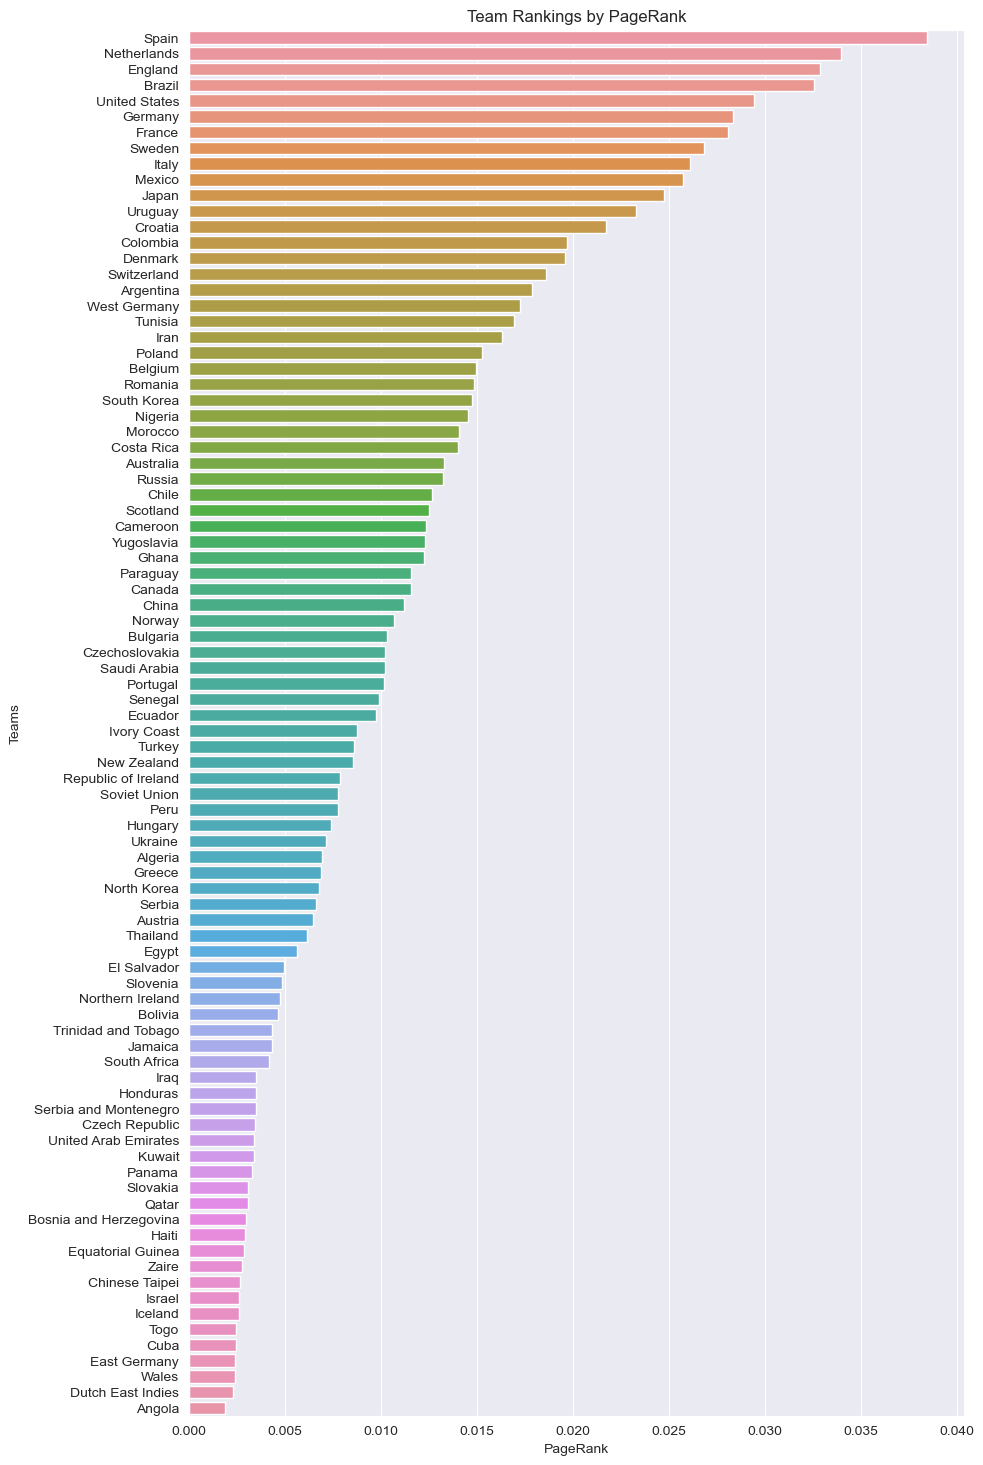

In [34]:
# Create a directed graph based on match outcomes
G = nx.DiGraph()

# Add matches as directed edges in the graph with weights based on match outcome
for index, row in matches.iterrows():
    G.add_edge(row['home_team_name'], row['away_team_name'], weight=row['outcome'])

# Apply PageRank algorithm to rank teams
pagerank = nx.pagerank(G)
pagerank_df = pd.DataFrame(list(pagerank.items()), columns=['Team', 'PageRank']).sort_values(by='PageRank', ascending=False)

# Visualizing the PageRank of teams
plt.figure(figsize=(10,18))
sns.barplot(x='PageRank', y='Team', data=pagerank_df)
plt.title('Team Rankings by PageRank')
plt.xlabel('PageRank')
plt.ylabel('Teams')
plt.show()

Top 10 Teams by PageRank:
             Team  PageRank
19          Spain  0.038462
22    Netherlands  0.033977
27        England  0.032884
5          Brazil  0.032558
2   United States  0.029433
15        Germany  0.028370
0          France  0.028097
20         Sweden  0.026842
18          Italy  0.026136
1          Mexico  0.025735


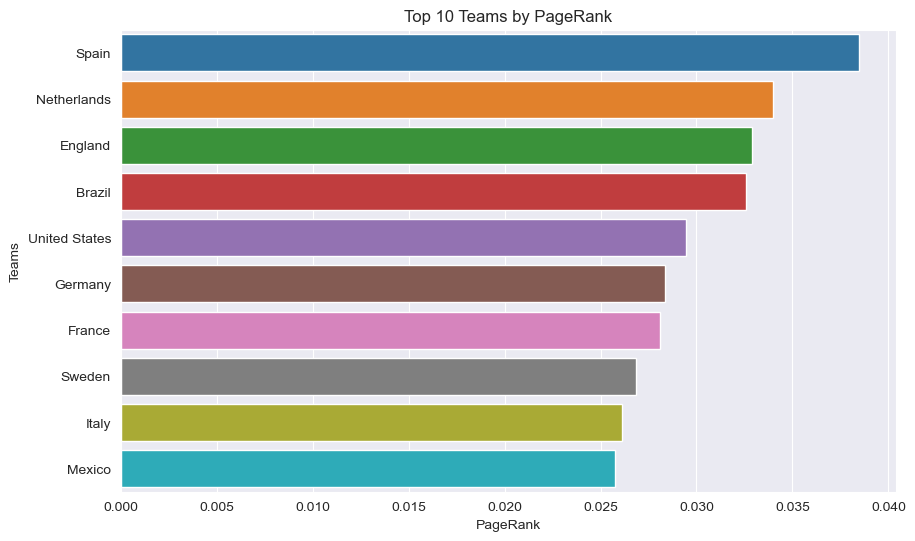

In [35]:
# Analyze and explain the PageRank results
print("Top 10 Teams by PageRank:")
print(pagerank_df.head(10))  # Show top 10 teams by PageRank

plt.figure(figsize=(10, 6))
sns.barplot(x='PageRank', y='Team', data=pagerank_df.head(10))
plt.title('Top 10 Teams by PageRank')
plt.xlabel('PageRank')
plt.ylabel('Teams')
plt.show()

The PageRank algorithm measures the "importance" or "influence" of teams based on the matches they've played. The algorithm takes into account both:
*   Direct match outcomes: Winning more matches increases a team’s influence.
*   The strength of opponents: Winning against stronger opponents or playing in more significant matches boosts a team’s PageRank score.

PageRank Interpretation:

*   Teams ranked higher in the PageRank algorithm are those that either:
  *   Consistently perform well (win many matches).
  *   Play against other highly ranked teams, meaning they influence the outcome of the tournament more significantly.

For example:
  *   Spain and Netherlands rank highly because they either consistently win matches or frequently face top-tier opponents. This ranking reflects their importance in the tournament, but it doesn’t necessarily mean they won the most matches—it reflects their central role in shaping the overall tournament dynamics.

Significance of Higher PageRank:

  *   A higher PageRank score means a team plays a key role in the tournament, either by being a strong team themselves or by frequently competing against other strong teams. These teams have a significant impact on the tournament structure and outcomes.


## Community Detection

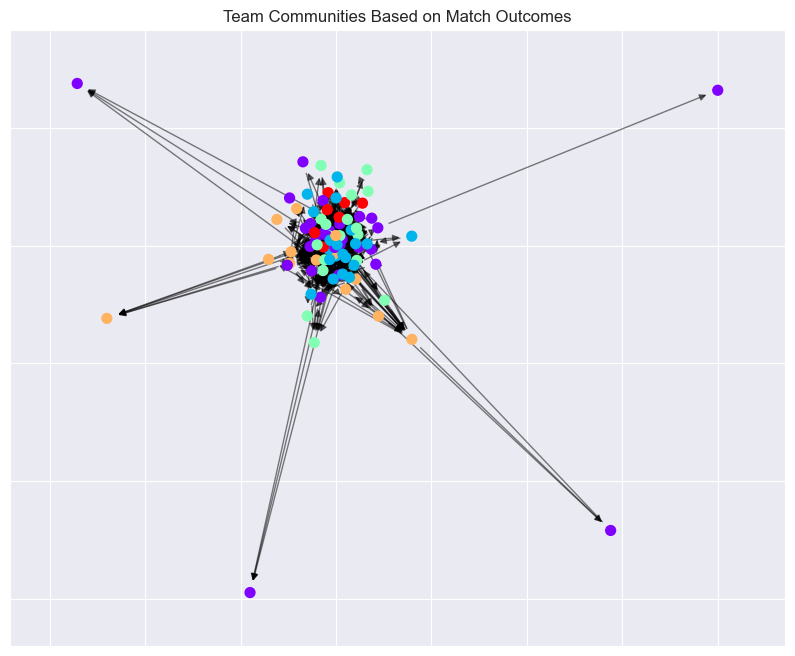

In [36]:
# Apply community detection
communities = nx.community.greedy_modularity_communities(G)

# Visualizing the team communities
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G)

# Assign a color to each community
color_map = []
for node in G:
    for i, community in enumerate(communities):
        if node in community:
            color_map.append(i)

nx.draw_networkx_nodes(G, pos, node_size=50, node_color=color_map, cmap=plt.get_cmap('rainbow'))
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.title("Team Communities Based on Match Outcomes")
plt.show()

# Assign teams to communities
community_dict = {}
for i, community in enumerate(communities):
    for team in community:
        community_dict[team] = i
matches['community'] = matches['home_team_name'].map(community_dict)

Community Summary (Average Performance Metrics):
           home_team_goals  away_team_goals  home_team_form  away_team_form
community                                                                  
0                 2.029083         1.013423        1.015660       -1.015660
1                 1.934932         1.133562        0.801370       -0.801370
2                 1.383838         1.136364        0.247475       -0.247475
3                 1.352564         1.250000        0.102564       -0.102564
4                 1.916129         1.154839        0.761290       -0.761290


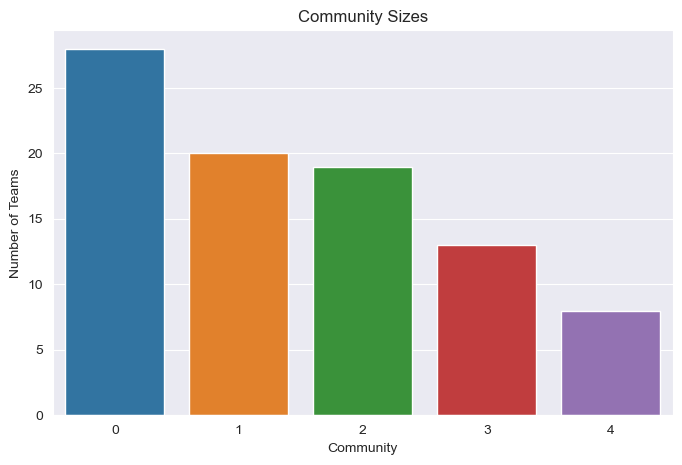

In [37]:
# Group by community and summarize performance
community_summary = matches.groupby('community')[numeric_columns].mean()[['home_team_goals', 'away_team_goals', 'home_team_form', 'away_team_form']]
print("Community Summary (Average Performance Metrics):")
print(community_summary)

# Visualize community sizes or characteristics
community_sizes = pd.Series(community_dict.values()).value_counts()
plt.figure(figsize=(8, 5))
sns.barplot(x=community_sizes.index, y=community_sizes.values)
plt.title('Community Sizes')
plt.xlabel('Community')
plt.ylabel('Number of Teams')
plt.show()

The communities detected using Community Detection represent groups of teams that are frequently matched against each other or share similar interaction patterns within the tournament. These groups are formed based on match history, geographic factors, or tournament stages.

Community Interpretation:
*   Each community contains teams that have frequent interactions, either by playing against each other multiple times or by sharing common characteristics (e.g., same geographic region or similar tournament progression). The community detection algorithm helps us uncover these underlying relationships.

By analyzing the detected communities, we can identify regional rivalries, frequent matchups, or teams that are commonly grouped together in tournament stages. For instance:
*   Teams from Europe might form a community due to their frequent encounters in World Cup and UEFA competitions.
*   Similarly, teams from South America may form another community based on their consistent participation in CONMEBOL and World Cup matchups.

In [38]:
!jupyter nbconvert --to html /content/drive/MyDrive/Colab\ Notebooks/21.ipynb

This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--execute
    Execute the notebook prior to export.
    Equivalent to: [--ExecutePr

[NbConvertApp] WARNING | pattern '/content/drive/MyDrive/Colab\\' matched no files
[NbConvertApp] WARNING | pattern 'Notebooks/21.ipynb' matched no files
